In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
GDRIVE_DIR = "/content/gdrive/My Drive/Structured Task (sentence decoding)"

Mounted at /content/gdrive


In [2]:
!wget n--load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56" -O files.zip && rm -rf /tmp/cookies.txt
!unzip files.zip
!rm files.zip

--2023-07-18 16:16:02--  http://n--load-cookies/
Resolving n--load-cookies (n--load-cookies)... failed: Name or service not known.
wget: unable to resolve host address ‘n--load-cookies’
/tmp/cookies.txt: Scheme missing.
--2023-07-18 16:16:03--  https://docs.google.com/uc?export=download&confirm=t&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56
Resolving docs.google.com (docs.google.com)... 74.125.132.102, 74.125.132.100, 74.125.132.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.132.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4qd2nd1rstmruts9irqfsrhs7h80cbr7/1689696900000/01333689271208460322/*/1xZaorRH-xxjfochvSesAhOTUg82_Xq56?e=download&uuid=a56577d7-8763-4d20-b530-4313386bbc97 [following]
--2023-07-18 16:16:03--  https://doc-0g-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4qd2nd1rstmruts9irqfsrhs7h80cbr7/168969690

In [3]:
from learn_decoder import *
import pandas as pd
import os
import numpy as np
data = read_matrix("imaging_data.csv", sep=",")

In [4]:
data.shape

(180, 170712)

In [5]:
concepts = np.genfromtxt('stimuli_180concepts.txt', dtype=np.dtype('U'))

### Load Word2Vec vectors to train the decoder and compare the results to HW3


In [6]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


fixing 'argumentatively' since gensim doesn't know that word.

In [7]:
wv_vectors = np.array([wv[c] if c != 'argumentatively' else wv['argumentative'] for c in concepts])
wv_vectors.shape

(180, 300)

## Load GloVe vectors (from pset3)

In [8]:
GLOVE_vectors = read_matrix("vectors_180concepts.GV42B300.txt", sep=" ")

In [9]:
def cosine_similarity(x: np.ndarray, y: np.ndarray) -> float:
    return np.dot(x,y)/(np.sqrt(np.dot(x,x))*np.sqrt(np.dot(y,y)))

### define functions

In [10]:
def create_folds(test_fold_size, fold_index, total_entries):
    # If it's the first fold
    if fold_index == 0:
        train_indices = list(range(test_fold_size, total_entries))
        test_indices = list(range(test_fold_size))
    # If it's the last fold
    elif fold_index == 19:
        train_indices = list(range(0, test_fold_size * 19))
        test_indices = list(range(test_fold_size * 19, total_entries))
    # For all other folds in between
    else:
        train_indices = list(range(0, test_fold_size * fold_index)) + \
                        list(range(test_fold_size * (fold_index + 1), total_entries))
        test_indices = list(range(test_fold_size * fold_index, test_fold_size * (fold_index + 1)))

    return train_indices, test_indices


### Train The Decoder On Word2Vec vectors

In [11]:
folds_scores_wv = []
accuracy_wv={}
n = len(data)
test_fold_size= int(n/20)
for i in range(20):
  rankings = 0
  train_idx, test_idx = create_folds(test_fold_size,i,n)
  dtrain,dtest = data[train_idx], data[test_idx]
  vtrain,vtest = wv_vectors[train_idx], wv_vectors[test_idx]
  w2v_decoder = learn_decoder(dtrain,vtrain).T
  decoded_vectors_w2v = [np.dot(w2v_decoder,voxel) for voxel in dtest]
  for vec,test_id in zip(decoded_vectors_w2v,test_idx):
    true_vector,true_concept=wv_vectors[test_id],concepts[test_id]
    similarities={c:cosine_similarity(vec,v) for v,c in zip(wv_vectors,concepts)}
    similarities=dict(sorted(similarities.items(), key=lambda item: -item[1]))
    true_concept_idx=list(similarities.keys()).index(true_concept)+1
    accuracy_wv[true_concept]=true_concept_idx
    rankings+=true_concept_idx
  folds_scores_wv.append(rankings/test_fold_size)

In [12]:
print("Average accuracy:")
print(np.mean(list(accuracy_wv.values())))

Average accuracy:
60.53333333333333


### Train The Decoder On GLOVE Vectors As we did in HW3 assignment 3

In [13]:
folds_scores_glove = []
accuracy_gl={}
n = len(data)
test_fold_size= int(n/20)
for i in range(20):
  rankings = 0
  train_idx, test_idx = create_folds(test_fold_size,i,n)
  dtrain,dtest = data[train_idx], data[test_idx]
  vtrain,vtest = GLOVE_vectors[train_idx], GLOVE_vectors[test_idx]
  decoder_GLOVE = learn_decoder(dtrain,vtrain).T
  decoded_vectors_GLOVE = [np.dot(decoder_GLOVE,voxel) for voxel in dtest]
  for vec,test_id in zip(decoded_vectors_GLOVE,test_idx):
    true_vector,true_concept=GLOVE_vectors[test_id],concepts[test_id]
    similarities={c:cosine_similarity(vec,v) for v,c in zip(GLOVE_vectors,concepts)}
    similarities=dict(sorted(similarities.items(), key=lambda item: -item[1]))
    true_concept_idx=list(similarities.keys()).index(true_concept)+1
    accuracy_gl[true_concept]=true_concept_idx
    rankings+=true_concept_idx
  folds_scores_glove.append(rankings/test_fold_size)

In [14]:
print("Average accuracy:")
print(np.mean(list(accuracy_gl.values())))

Average accuracy:
61.96111111111111


## Results - Comparison Between the results obtained with W2V Vectors and GLOVE Vectors

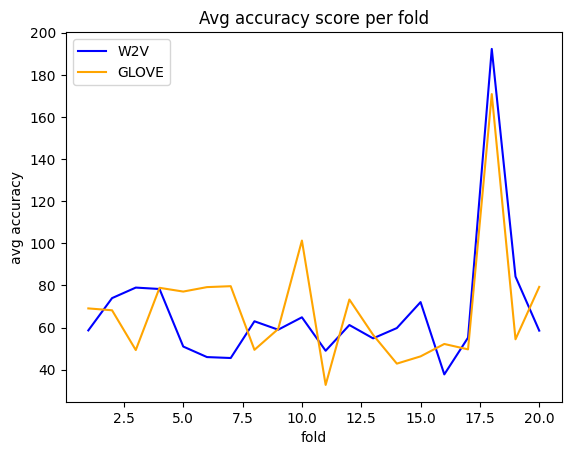

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(1,21),folds_scores_wv, color='blue')
plt.plot(range(1,21),folds_scores_glove, color='orange')
plt.title('Avg accuracy score per fold')
plt.xlabel('fold')
plt.ylabel('avg accuracy')
plt.legend(['W2V','GLOVE'])

In [16]:
accuracy_gl_sorted = sorted(accuracy_gl.items(), key=lambda item: item[1])
print('Best Decoded Concepts Using Glove')
for word,score in accuracy_gl_sorted[:20]:
  print(f'**{word}**   Glove Accuracy: {score}, W2v Accuracy: {accuracy_wv[word]}')
print('\n worst Decoded Concepts Using Glove')
for word,score in accuracy_gl_sorted[-20:]:
  print(word)
  print(f'**{word}**  Glove Accuracy: {score}, W2v Accuracy: {accuracy_wv[word]}')

Best Decoded Concepts Using Glove
**do**   Glove Accuracy: 1, W2v Accuracy: 7
**food**   Glove Accuracy: 1, W2v Accuracy: 4
**time**   Glove Accuracy: 1, W2v Accuracy: 96
**great**   Glove Accuracy: 2, W2v Accuracy: 48
**laugh**   Glove Accuracy: 4, W2v Accuracy: 1
**feeling**   Glove Accuracy: 5, W2v Accuracy: 9
**stupid**   Glove Accuracy: 5, W2v Accuracy: 1
**hair**   Glove Accuracy: 6, W2v Accuracy: 3
**lady**   Glove Accuracy: 6, W2v Accuracy: 14
**left**   Glove Accuracy: 6, W2v Accuracy: 73
**extremely**   Glove Accuracy: 7, W2v Accuracy: 103
**money**   Glove Accuracy: 7, W2v Accuracy: 39
**ability**   Glove Accuracy: 8, W2v Accuracy: 71
**big**   Glove Accuracy: 8, W2v Accuracy: 16
**crazy**   Glove Accuracy: 8, W2v Accuracy: 7
**play**   Glove Accuracy: 8, W2v Accuracy: 15
**music**   Glove Accuracy: 9, W2v Accuracy: 8
**picture**   Glove Accuracy: 9, W2v Accuracy: 61
**building**   Glove Accuracy: 10, W2v Accuracy: 17
**construction**   Glove Accuracy: 10, W2v Accuracy: 98



In [17]:
accuracy_wv_sorted = sorted(accuracy_wv.items(), key=lambda item: item[1])
print('Best Decoded Concepts Using w2v')
for word,score in accuracy_wv_sorted[:20]:
  print(f'**{word}**  W2v Accuracy: {score}, Glove Accuracy: {accuracy_gl[word]}')
print('\n worst Decoded Concepts Using w2v')
for word,score in accuracy_gl_sorted[-20:]:
  print(f'**{word}**  W2v Accuracy: {score}, Glove Accuracy: {accuracy_gl[word]}')

Best Decoded Concepts Using w2v
**laugh**  W2v Accuracy: 1, Glove Accuracy: 4
**stupid**  W2v Accuracy: 1, Glove Accuracy: 5
**emotion**  W2v Accuracy: 2, Glove Accuracy: 42
**hair**  W2v Accuracy: 3, Glove Accuracy: 6
**food**  W2v Accuracy: 4, Glove Accuracy: 1
**seafood**  W2v Accuracy: 4, Glove Accuracy: 83
**liar**  W2v Accuracy: 5, Glove Accuracy: 114
**smiling**  W2v Accuracy: 5, Glove Accuracy: 34
**soul**  W2v Accuracy: 5, Glove Accuracy: 24
**crazy**  W2v Accuracy: 7, Glove Accuracy: 8
**do**  W2v Accuracy: 7, Glove Accuracy: 1
**useless**  W2v Accuracy: 7, Glove Accuracy: 34
**dig**  W2v Accuracy: 8, Glove Accuracy: 43
**fish**  W2v Accuracy: 8, Glove Accuracy: 11
**music**  W2v Accuracy: 8, Glove Accuracy: 9
**silly**  W2v Accuracy: 8, Glove Accuracy: 14
**bird**  W2v Accuracy: 9, Glove Accuracy: 60
**dressing**  W2v Accuracy: 9, Glove Accuracy: 66
**feeling**  W2v Accuracy: 9, Glove Accuracy: 5
**sexy**  W2v Accuracy: 9, Glove Accuracy: 57

 worst Decoded Concepts Using w2

In [18]:
N = 30

## Best Intersection

In [19]:
best_wv = [x[0] for x in accuracy_wv_sorted[:N]]
best_gl = [x[0] for x in accuracy_gl_sorted[:N]]
best = [x for x in best_gl if x in best_wv]
for word in best:
  print(f'{word} - Glove Score: {accuracy_gl[word]}, W2V Score: {accuracy_wv[word]}')

do - Glove Score: 1, W2V Score: 7
food - Glove Score: 1, W2V Score: 4
laugh - Glove Score: 4, W2V Score: 1
feeling - Glove Score: 5, W2V Score: 9
stupid - Glove Score: 5, W2V Score: 1
hair - Glove Score: 6, W2V Score: 3
lady - Glove Score: 6, W2V Score: 14
crazy - Glove Score: 8, W2V Score: 7
play - Glove Score: 8, W2V Score: 15
music - Glove Score: 9, W2V Score: 8
fish - Glove Score: 11, W2V Score: 8
wear - Glove Score: 13, W2V Score: 11


In [20]:
worst_wv = [x[0] for x in accuracy_wv_sorted[-N:]]
worst_gl = [x[0] for x in accuracy_gl_sorted[-N:]]
worst = [x for x in worst_wv if x in worst_gl]
for word in worst:
  print(f'{word} - Glove Score: {accuracy_gl[word]}, W2V Score: {accuracy_wv[word]}')

residence - Glove Score: 132, W2V Score: 107
applause - Glove Score: 175, W2V Score: 114
dissolve - Glove Score: 167, W2V Score: 115
camera - Glove Score: 122, W2V Score: 119
vacation - Glove Score: 152, W2V Score: 128
movie - Glove Score: 158, W2V Score: 133
driver - Glove Score: 125, W2V Score: 137
bed - Glove Score: 136, W2V Score: 138
charity - Glove Score: 135, W2V Score: 147


In [21]:
worst_wv_best_gl =  [x for x in worst_wv if x in best_gl]
for word in worst_wv_best_gl:
  print(f'{word} - Glove Score: {accuracy_gl[word]}, W2V Score: {accuracy_wv[word]}')

In [22]:
best_wv_worst_gl =  [x for x in best_wv if x in worst_gl]
for word in best_wv_worst_gl:
  print(f'{word} - Glove Score: {accuracy_gl[word]}, W2V Score: {accuracy_wv[word]}')

##First, We will train the decoder on the entire dataset instead of 18-fold-cross-validation and work with a dataset that fits the shape of the neuraldata.

In [23]:
ndata = pd.read_csv(os.path.join(GDRIVE_DIR,'neuralData_for_EXP1.csv'))
dtrain = ndata.iloc[:, 1:].values
vtrain = read_matrix("vectors_180concepts.GV42B300.txt", sep=" ")
decoder_GLOVE_full = learn_decoder(dtrain,vtrain).T

In [24]:
decoder_GLOVE_full.shape

(300, 185866)

In [25]:
import pickle
import os
with open(os.path.join(GDRIVE_DIR,'EXP2.pkl'),'rb') as file:
  exp2_pkl = pickle.load(file)
avg_sen_2 = read_matrix(os.path.join(GDRIVE_DIR,'vectors_384sentences.GV42B300.average.txt'),sep=" ")

In [26]:
print(avg_sen_2.shape)
print(exp2_pkl['Fmridata'].shape)

(384, 300)
(384, 185866)


In [27]:
# init lists and accuracies_dicts for the topics and the subtopics

exp2_keyPassageTopics = list(set([x[0] for x in exp2_pkl['keyPassageCategory'][0]]))
exp2_keyPassagesSubtopics = list(set([x[0][0] for x in exp2_pkl['keyPassages']]))

exp2_topic_accuracies = {k:[] for k in exp2_keyPassageTopics}
exp2_subtopic_accuracies = {k:[] for k in exp2_keyPassagesSubtopics}

In [28]:
accuracy_exp2=[]
rankings=0
for idx,voxel in enumerate(exp2_pkl['Fmridata']):
  decoded = np.dot(decoder_GLOVE_full,voxel)
  true_vec = avg_sen_2[idx]
  similarities = {i:cosine_similarity(decoded,v) for i,v in enumerate(avg_sen_2)}
  similarities = dict(sorted(similarities.items(), key=lambda item: -item[1]))
  true_concept_idx = list(similarities.keys()).index(idx)+1
  accuracy_exp2.append(true_concept_idx)
  rankings += true_concept_idx

  passage_id = exp2_pkl['labelsPassageForEachSentence'][idx].item()-1
  subtopic = exp2_pkl['keyPassages'][passage_id][0][0]
  topic_id = exp2_pkl['labelsPassageCategory'][passage_id].item()-1
  topic = exp2_pkl['keyPassageCategory'][0][topic_id][0]

  exp2_topic_accuracies[topic].append(true_concept_idx)
  exp2_subtopic_accuracies[subtopic].append(true_concept_idx)

exp2_topic_accuracies = {k:np.mean(v) for k,v in exp2_topic_accuracies.items()}
exp2_subtopic_accuracies = {k:np.mean(v) for k,v in exp2_subtopic_accuracies.items()}

In [29]:
np.mean(accuracy_exp2)

156.92708333333334

## Decoding Exp3 data



In [30]:
import pickle
import os
with open(os.path.join(GDRIVE_DIR,'EXP3.pkl'),'rb') as file:
  exp3_pkl = pickle.load(file)
avg_sen_3 = read_matrix(os.path.join(GDRIVE_DIR,'vectors_243sentences.GV42B300.average.txt'),sep=" ")

In [31]:
# init lists and accuracies_dicts for the topics and the subtopics

exp3_keyPassageTopics = list(set([x[0] for x in exp3_pkl['keyPassageCategory'][0]]))
exp3_keyPassagesSubtopics = list(set([x[0][0] for x in exp3_pkl['keyPassages']]))

exp3_topic_accuracies = {k:[] for k in exp3_keyPassageTopics}
exp3_subtopic_accuracies = {k:[] for k in exp3_keyPassagesSubtopics}

In [32]:
accuracy=[]
rankings=0
for idx,voxel in enumerate(exp3_pkl['Fmridata']):
  decoded = np.dot(decoder_GLOVE_full,voxel)
  true_vec = avg_sen_3[idx]
  similarities={i:cosine_similarity(decoded,v) for i,v in enumerate(avg_sen_3)}
  similarities=dict(sorted(similarities.items(), key=lambda item: -item[1]))
  true_concept_idx=list(similarities.keys()).index(idx)+1
  accuracy.append(true_concept_idx)
  rankings+=true_concept_idx

  passage_id = exp3_pkl['labelsPassageForEachSentence'][idx].item()-1
  subtopic = exp3_pkl['keyPassages'][passage_id][0][0]
  topic_id = exp3_pkl['labelsPassageCategory'][passage_id].item()-1
  topic = exp3_pkl['keyPassageCategory'][0][topic_id][0]

  exp3_topic_accuracies[topic].append(true_concept_idx)
  exp3_subtopic_accuracies[subtopic].append(true_concept_idx)

exp3_topic_accuracies = {k:np.mean(v) for k,v in exp3_topic_accuracies.items()}
exp3_subtopic_accuracies = {k:np.mean(v) for k,v in exp3_subtopic_accuracies.items()}

In [33]:
np.mean(accuracy)

100.7448559670782

In [34]:
with open (os.path.join(GDRIVE_DIR,'stimuli_243sentences.txt'),'rb') as file:
  sen_243= file.readlines()

##Results

In [35]:
exp2_topic_accuracies = sorted(exp2_topic_accuracies.items(), key=lambda item: item[1])
exp2_subtopic_accuracies = sorted(exp2_subtopic_accuracies.items(), key=lambda item: item[1])

exp3_topic_accuracies = sorted(exp3_topic_accuracies.items(), key=lambda item: item[1])
exp3_subtopic_accuracies = sorted(exp3_subtopic_accuracies.items(), key=lambda item: item[1])

In [36]:
print("best topics (exp2 and exp3)")
print(exp2_topic_accuracies[0:5])
print(exp3_topic_accuracies[0:5])
print()
print("worst topics (exp2 and exp3)")
print(exp2_topic_accuracies[-5:])
print(exp3_topic_accuracies[-5:])
print()
print("best subtopics (exp2)")
print(exp2_subtopic_accuracies[0:5])
# print(exp3_subtopic_accuracies[0:5])
print()
print("worst subtopics (exp2)")
print(exp2_subtopic_accuracies[-5:])
# print(exp3_subtopic_accuracies[-5:])
print()

best topics (exp2 and exp3)
[('body_part', 70.4375), ('human', 92.75), ('drink_non_alcoholic', 98.9375), ('dwelling', 113.6875), ('appliance', 113.75)]
[('dreams', 52.8), ('stress', 58.2), ('castle', 59.1), ('opera', 63.63636363636363), ('bone_fracture', 68.0909090909091)]

worst topics (exp2 and exp3)
[('music', 185.0), ('vehicles_transport', 186.6875), ('animal', 196.25), ('vegetable', 237.625), ('profession', 249.125)]
[('pharmacist', 136.6), ('pyramid', 147.2), ('lawn_mower', 148.1), ('owl', 148.6), ('beekeeping', 169.8181818181818)]

best subtopics (exp2)
[('Coffee', 18.75), ('Library', 29.75), ('Finger', 48.75), ('Girl', 51.75), ('Drought', 56.75)]

worst subtopics (exp2)
[('Butterfly', 284.5), ('Whale', 286.25), ('Broccoli', 289.5), ('Screwdriver', 310.25), ('Carpenter', 338.5)]



In [37]:
sub_2_topic_exp2 = {}
for idx in range(384):
  passage_id = exp2_pkl['labelsPassageForEachSentence'][idx].item()-1
  subtopic = exp2_pkl['keyPassages'][passage_id][0][0]
  if subtopic not in sub_2_topic_exp2.keys():
    topic_id = exp2_pkl['labelsPassageCategory'][passage_id].item()-1
    topic = exp2_pkl['keyPassageCategory'][0][topic_id][0]
    sub_2_topic_exp2[subtopic] = topic

In [38]:
best_sub= [('Coffee', 18.75), ('Library', 29.75), ('Finger', 48.75), ('Girl', 51.75), ('Drought', 56.75)]
for x,s in best_sub:
  print(f'{x} -> {sub_2_topic_exp2[x]}')
worst_sub = [('Butterfly', 284.5), ('Whale', 286.25), ('Broccoli', 289.5), ('Screwdriver', 310.25), ('Carpenter', 338.5)]
for x,s in worst_sub:
  print(f'{x} -> {sub_2_topic_exp2[x]}')

Coffee -> drink_non_alcoholic
Library -> place
Finger -> body_part
Girl -> human
Drought -> disaster
Butterfly -> insect
Whale -> animal
Broccoli -> vegetable
Screwdriver -> tool
Carpenter -> profession


In [39]:
sub_2_topic_exp3 = {}
for idx in range(243):
  passage_id = exp3_pkl['labelsPassageForEachSentence'][idx].item()-1
  subtopic = exp3_pkl['keyPassages'][passage_id][0][0]
  if subtopic not in sub_2_topic_exp3.keys():
    topic_id = exp3_pkl['labelsPassageCategory'][passage_id].item()-1
    topic = exp3_pkl['keyPassageCategory'][0][topic_id][0]
    sub_2_topic_exp3[subtopic] = topic

In [40]:
sub_2_topic_exp3

{'beekeeping': 'beekeeping',
 'dreams': 'dreams',
 'gambling': 'gambling',
 'hurricane': 'hurricane',
 'ice_cream': 'ice_cream',
 'lawn_mower': 'lawn_mower',
 'astronaut': 'astronaut',
 'computer_graphics': 'computer_graphics',
 'law_school': 'law_school',
 'pharmacist': 'pharmacist',
 'stress': 'stress',
 'tuxedo': 'tuxedo',
 'blindness': 'blindness',
 'taste': 'taste',
 'bone_fracture': 'bone_fracture',
 'infection': 'infection',
 'opera': 'opera',
 'painter': 'painter',
 'owl': 'owl',
 'polar_bear': 'polar_bear',
 'castle': 'castle',
 'pyramid': 'pyramid',
 'rock_climbing': 'rock_climbing',
 'skiing': 'skiing'}

In [41]:
!pip install transformers
!pip install SentencePiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.1 MB/s eta 0:00:00


In [42]:
from transformers import LlamaForCausalLM, LlamaTokenizer
import torch
import pickle
import os

In [43]:
with open(os.path.join(GDRIVE_DIR,'EXP2.pkl'),'rb') as file:
  exp2_pkl = pickle.load(file)
avg_sen_2 = read_matrix(os.path.join(GDRIVE_DIR,'vectors_384sentences.GV42B300.average.txt'),sep=" ")

In [44]:
with open(os.path.join(GDRIVE_DIR,'EXP3.pkl'),'rb') as file:
  exp3_pkl = pickle.load(file)
avg_sen_3 = read_matrix(os.path.join(GDRIVE_DIR,'vectors_243sentences.GV42B300.average.txt'),sep=" ")

## Task 1 - Training a decoder on EXP2 data using GLoVe and BERT Vectors and compare the results

In [45]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-mini')
model = BertModel.from_pretrained('prajjwal1/bert-mini')

bert_vectors = []
for s in exp2_pkl['keySentences']:
  s = s[0][0].item()
  inputs = tokenizer(s, return_tensors="pt")
  outputs = model(**inputs)
  cls = outputs.last_hidden_state.squeeze()[0].detach().numpy()
  bert_vectors.append(cls)

bert_vectors = np.array(bert_vectors)

Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [46]:
folds_scores_bert = []
accuracy={}
data = exp2_pkl['Fmridata']
n = len(data)
test_fold_size= int(n/20)
for i in range(20):
  rankings = 0
  train_idx, test_idx = create_folds(test_fold_size,i,n)
  dtrain,dtest = data[train_idx], data[test_idx]
  vtrain,vtest = bert_vectors[train_idx], bert_vectors[test_idx]
  decoder_bert = learn_decoder(dtrain,vtrain).T
  decoded_vectors_bert = [np.dot(decoder_bert,voxel) for voxel in dtest]
  for decoded,idx in zip(decoded_vectors_bert, test_idx):
    true_vec = bert_vectors[idx]
    similarities = {i:cosine_similarity(decoded,v) for i,v in enumerate(bert_vectors)}
    similarities = dict(sorted(similarities.items(), key=lambda item: -item[1]))
    true_concept_idx = list(similarities.keys()).index(idx)+1
    # accuracy.append(true_concept_idx)
    rankings += true_concept_idx
  folds_scores_bert.append(rankings/test_fold_size)

In [47]:
folds_scores_glove_exp2 = []
accuracy={}
data = exp2_pkl['Fmridata']
n = len(data)
test_fold_size= int(n/20)
for i in range(20):
  rankings = 0
  train_idx, test_idx = create_folds(test_fold_size,i,n)
  dtrain,dtest = data[train_idx], data[test_idx]
  vtrain,vtest = avg_sen_2[train_idx], avg_sen_2[test_idx]
  decoder_glove_exp2 = learn_decoder(dtrain,vtrain).T
  decoded_vectors_glove_exp2 = [np.dot(decoder_glove_exp2,voxel) for voxel in dtest]
  for decoded,idx in zip(decoded_vectors_glove_exp2,test_idx):
    true_vec = avg_sen_2[idx]
    similarities = {i:cosine_similarity(decoded,v) for i,v in enumerate(avg_sen_2)}
    similarities = dict(sorted(similarities.items(), key=lambda item: -item[1]))
    true_concept_idx = list(similarities.keys()).index(idx)+1
    rankings += true_concept_idx
  folds_scores_glove_exp2.append(rankings/test_fold_size)

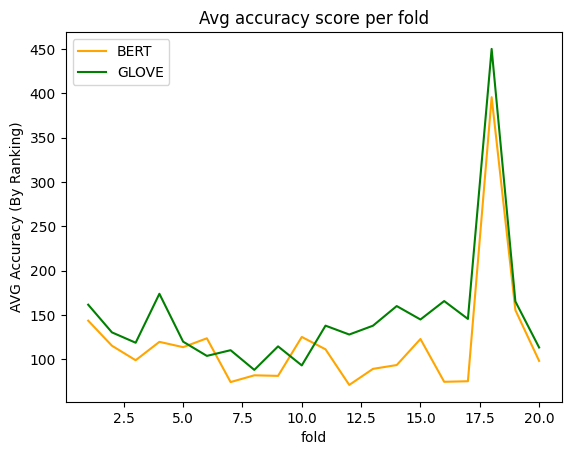

In [48]:
import matplotlib.pyplot as plt

plt.plot(range(1,21),folds_scores_bert, color='orange')
plt.plot(range(1,21),folds_scores_glove_exp2, color='green')
plt.title('Avg accuracy score per fold')
plt.xlabel('fold')
plt.ylabel('AVG Accuracy (By Ranking)')
plt.legend(['BERT','GLOVE'])

In [49]:
print(f'bert mean {np.mean(folds_scores_bert)} GLOVE mean: {np.mean(folds_scores_glove_exp2)}')

bert mean 118.24736842105264 GLOVE mean: 148.1421052631579


In [50]:
accuracy=[]
rankings=0
for idx,voxel in enumerate(exp2_pkl['Fmridata']):
  decoded = np.dot(decoder_GLOVE_full,voxel)
  true_vec = avg_sen_2[idx]
  similarities = {i:cosine_similarity(decoded,v) for i,v in enumerate(avg_sen_2)}
  similarities = dict(sorted(similarities.items(), key=lambda item: -item[1]))
  true_concept_idx = list(similarities.keys()).index(idx)+1
  accuracy.append(true_concept_idx)
  rankings += true_concept_idx

## Task 2 - Build a brain-encoder model using GloVe and BERT vectors

In [51]:
import numpy as np
import statsmodels.api as sm
import tqdm
import matplotlib.pyplot as plt


def calc_regressions(sentences_embedding, data):
  X = sentences_embedding
  X = sm.add_constant(X)
  R_2_voxels = []
  R_2_adj_voxels=[]
  P_vals = []
  for voxel_id in tqdm.tqdm(range(data.shape[1])):
    Y = data[:,voxel_id]
    model = sm.OLS(Y,X)
    results = model.fit()
    R_2_voxels.append(results.rsquared)
    P_vals.append(results.f_pvalue)
    R_2_adj_voxels.append(results.rsquared_adj)

  R_2_voxels = np.array(R_2_voxels)
  P_vals = np.array(P_vals)
  R_2_adj_voxels = np.array(R_2_adj_voxels)

  return P_vals,R_2_voxels,R_2_adj_voxels


In [52]:
def print_results(P_vals, R_2_voxels, R_2_adj_voxels, name):
  print("Analysis for: {}".format(name))
  print("Voxel Analysis:")
  print("Significantly associated voxels (%): {:.2f}".format(np.nanmean(P_vals<0.05)*100))
  print("Non-NaN p-values (%): {:.2f}".format(np.mean(~np.isnan(P_vals))*100))
  print("Mean p-value: {:.4f}".format(np.nanmean(P_vals)))
  print("Standard Deviation of p-values: {:.4f}\n".format(np.nanstd(P_vals)))

  print("R-squared Analysis:")
  print("Mean: {:.4f}".format(np.nanmean(R_2_voxels)))
  print("Standard Deviation: {:.4f}".format(np.nanstd(R_2_voxels)))
  print("Non-NaN R-squared (%): {:.2f}\n".format(np.mean(~np.isnan(R_2_voxels))*100))

  print("Adjusted R-squared Analysis:")
  print("Mean: {:.4f}".format(np.nanmean(R_2_adj_voxels)))
  print("Standard Deviation: {:.4f}".format(np.nanstd(R_2_adj_voxels)))
  print("Non-NaN Adjusted R-squared (%): {:.2f}\n".format(np.mean(~np.isnan(R_2_adj_voxels))*100))

  print("Significant-Only Analysis: P_Value")
  P_vals_sign = P_vals<0.05
  print("Mean p-value: {:.4f}".format(np.nanmean(P_vals[P_vals_sign])))
  print("Standard Deviation of p-values: {:.4f}".format(np.nanstd(P_vals[P_vals_sign])))

  print("Mean R-squared: {:.4f}".format(np.nanmean(R_2_voxels[P_vals_sign])))
  print("Standard Deviation of R-squared: {:.4f}".format(np.nanstd(R_2_voxels[P_vals_sign])))

  print("Mean Adjusted R-squared: {:.4f}".format(np.nanmean(R_2_adj_voxels[P_vals_sign])))
  print("Standard Deviation of Adjusted R-squared: {:.4f}".format(np.nanstd(R_2_adj_voxels[P_vals_sign])))

  print()
  print("Significant-Only Analysis: R_2_Value")
  R_2_vals_sign = R_2_voxels>0.75
  print("Mean p-value: {:.4f}".format(np.nanmean(P_vals[R_2_vals_sign])))
  print("Standard Deviation of p-values: {:.4f}".format(np.nanstd(P_vals[R_2_vals_sign])))

  print("Mean R-squared: {:.4f}".format(np.nanmean(R_2_voxels[R_2_vals_sign])))
  print("Standard Deviation of R-squared: {:.4f}".format(np.nanstd(R_2_voxels[R_2_vals_sign])))

  print("Mean Adjusted R-squared: {:.4f}".format(np.nanmean(R_2_adj_voxels[R_2_vals_sign])))
  print("Standard Deviation of Adjusted R-squared: {:.4f}".format(np.nanstd(R_2_adj_voxels[R_2_vals_sign])))


In [ ]:
P_vals_glove,R_2_voxels_glove,R_2_adj_voxels_glove = calc_regressions(avg_sen_2,exp2_pkl['Fmridata'])

In [ ]:
import pickle

with open('results.pkl', 'rb') as f:
    data = pickle.load(f)
P_vals_bert = data['P_vals_bert']
R_2_voxels_bert = data['R_2_voxels_bert']
R_2_adj_voxels_bert = data['R_2_adj_voxels_bert']

with open('my_saved_data.pkl', 'rb') as f:
  data2 = pickle.load(f)
P_vals_glove = data2["P_vals_glove"]
R_2_voxels_glove = data2["R_2_voxels_glove"]
R_2_adj_voxels_glove = data2["R_2_adj_voxels_glove"]

with open('bert_3_regs.pkl', 'rb') as f:
  P_vals_bert_3,R_2_voxels_bert_3,R_2_adj_voxels_bert_3 = pickle.load(f)

In [65]:
print_results(P_vals_glove,R_2_voxels_glove,R_2_adj_voxels_glove, 'GloVE Exp2')

Analysis for: GloVE Exp2
Voxel Analysis:
Significantly associated voxels (%): 15.98
Non-NaN p-values (%): 99.93
Mean p-value: 0.3153
Standard Deviation of p-values: 0.2595

R-squared Analysis:
Mean: 0.8028
Standard Deviation: 0.0275
Non-NaN R-squared (%): 99.93

Adjusted R-squared Analysis:
Mean: 0.0902
Standard Deviation: 0.1269
Non-NaN Adjusted R-squared (%): 99.93

Significant-Only Analysis: P_Value
Mean p-value: 0.0222
Standard Deviation of p-values: 0.0146
Mean R-squared: 0.8430
Standard Deviation of R-squared: 0.0104
Mean Adjusted R-squared: 0.2757
Standard Deviation of Adjusted R-squared: 0.0480

Significant-Only Analysis: R_2_Value
Mean p-value: 0.2956
Standard Deviation of p-values: 0.2391
Mean R-squared: 0.8049
Standard Deviation of R-squared: 0.0252
Mean Adjusted R-squared: 0.0999
Standard Deviation of Adjusted R-squared: 0.1164


In [64]:
def bert_vectors_embedding(data,tokenizer,model):
  bert_vectors = []
  for s in data:
    s = s[0][0].item()
    inputs = tokenizer(s, return_tensors="pt")
    outputs = model(**inputs)
    cls = outputs.last_hidden_state.squeeze()[0].detach().numpy()
    bert_vectors.append(cls)
  bert_vectors = np.array(bert_vectors)
  return bert_vectors

In [66]:
from transformers import BertTokenizer, BertModel
Bert_trained_model = 'prajjwal1/bert-mini'

tokenizer = BertTokenizer.from_pretrained(Bert_trained_model)
model = BertModel.from_pretrained(Bert_trained_model,output_hidden_states = True,)
bert_vectors_exp2 = bert_vectors_embedding(exp2_pkl['keySentences'],tokenizer,model)

Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
P_vals_bert,R_2_voxels_bert,R_2_adj_voxels_bert=calc_regressions(bert_vectors_exp2,exp2_pkl['Fmridata'])

In [67]:
print_results(P_vals_bert,R_2_voxels_bert,R_2_adj_voxels_bert, "BERT EXP2")

Analysis for: BERT EXP2
Voxel Analysis:
Significantly associated voxels (%): 17.25
Non-NaN p-values (%): 99.93
Mean p-value: 0.3635
Standard Deviation of p-values: 0.2940

R-squared Analysis:
Mean: 0.6866
Standard Deviation: 0.0378
Non-NaN R-squared (%): 99.93

Adjusted R-squared Analysis:
Mean: 0.0549
Standard Deviation: 0.1139
Non-NaN Adjusted R-squared (%): 99.93

Significant-Only Analysis: P_Value
Mean p-value: 0.0189
Standard Deviation of p-values: 0.0149
Mean R-squared: 0.7427
Standard Deviation of R-squared: 0.0158
Mean Adjusted R-squared: 0.2240
Standard Deviation of Adjusted R-squared: 0.0477

Significant-Only Analysis: R_2_Value
Mean p-value: 0.0024
Standard Deviation of p-values: 0.0018
Mean R-squared: 0.7641
Standard Deviation of R-squared: 0.0121
Mean Adjusted R-squared: 0.2885
Standard Deviation of Adjusted R-squared: 0.0364


In [68]:
from matplotlib.gridspec import SubplotSpec
import matplotlib.pyplot as plt

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    row.set_title(f'{title}\n', fontweight='semibold', fontsize=14)
    row.set_frame_on(False)
    row.axis('off')

def plot_results(P_vals,R_2_voxels,R_2_adj_voxels,is_sign, is_R2):
    cols = 3 if is_R2 else 2
    rows = 2
    title =  'Total Results'

    if is_sign:
        title = 'Significant Results'
        p_vals_sign_bool = {}
        for k in ['glove', 'bert']:
            p_vals_sign_bool[k] = P_vals[k] < 0.05
            P_vals[k] = P_vals[k][p_vals_sign_bool[k]]
            R_2_voxels[k] = R_2_voxels[k][p_vals_sign_bool[k]]
            R_2_adj_voxels[k] = R_2_adj_voxels[k][p_vals_sign_bool[k]]

    fig_size = (20, 12) if is_R2 else (16, 12)
    fig, axes = plt.subplots(rows, cols, figsize=fig_size, sharex='col')

    for ax in axes.ravel():
        ax.xaxis.set_tick_params(which='both', labelbottom=True)

    plt.suptitle(title, fontsize=16, fontweight='bold')

    axes[1][0].hist(P_vals['glove'], bins='auto', color='skyblue', edgecolor='black')
    axes[1][0].set_title('P values', fontsize=14)
    axes[1][0].set_xlabel('P values', fontsize=12)
    axes[1][0].set_ylabel('Frequency', fontsize=12)

    axes[1][1].hist(R_2_adj_voxels['glove'], bins='auto', color='skyblue', edgecolor='black')
    axes[1][1].set_title(r'Adjusted $R^2$', fontsize=14)
    axes[1][1].set_xlabel('Adjusted $R^2$', fontsize=12)
    axes[1][1].set_ylabel('Frequency', fontsize=12)

    axes[0][0].hist(P_vals['bert'], bins='auto', color='lightcoral', edgecolor='black')
    axes[0][0].set_title('P values', fontsize=14)
    axes[0][0].set_xlabel('P values', fontsize=12)
    axes[0][0].set_ylabel('Frequency', fontsize=12)

    axes[0][1].hist(R_2_adj_voxels['bert'], bins='auto', color='lightcoral', edgecolor='black')
    axes[0][1].set_title(r'Adjusted $R^2$', fontsize=14)
    axes[0][1].set_xlabel('Adjusted $R^2$', fontsize=12)
    axes[0][1].set_ylabel('Frequency', fontsize=12)

    if is_R2:
        axes[1][2].hist(R_2_voxels['glove'], bins='auto', color='skyblue', edgecolor='black')
        axes[1][2].set_title(r'$R^2$', fontsize=14)
        axes[1][2].set_xlabel(r'$R^2$', fontsize=12)
        axes[1][2].set_ylabel('Frequency', fontsize=12)

        axes[0][2].hist(R_2_voxels['bert'], bins='auto', color='lightcoral', edgecolor='black')
        axes[0][2].set_title(r'$R^2$', fontsize=14)
        axes[0][2].set_xlabel(r'$R^2$', fontsize=12)
        axes[0][2].set_ylabel('Frequency', fontsize=12)

    grid = plt.GridSpec(rows, cols)
    create_subtitle(fig, grid[0, ::], 'GloVe based Brain Encoder Results')
    create_subtitle(fig, grid[1, ::], 'BERT based Brain Encoder Results')



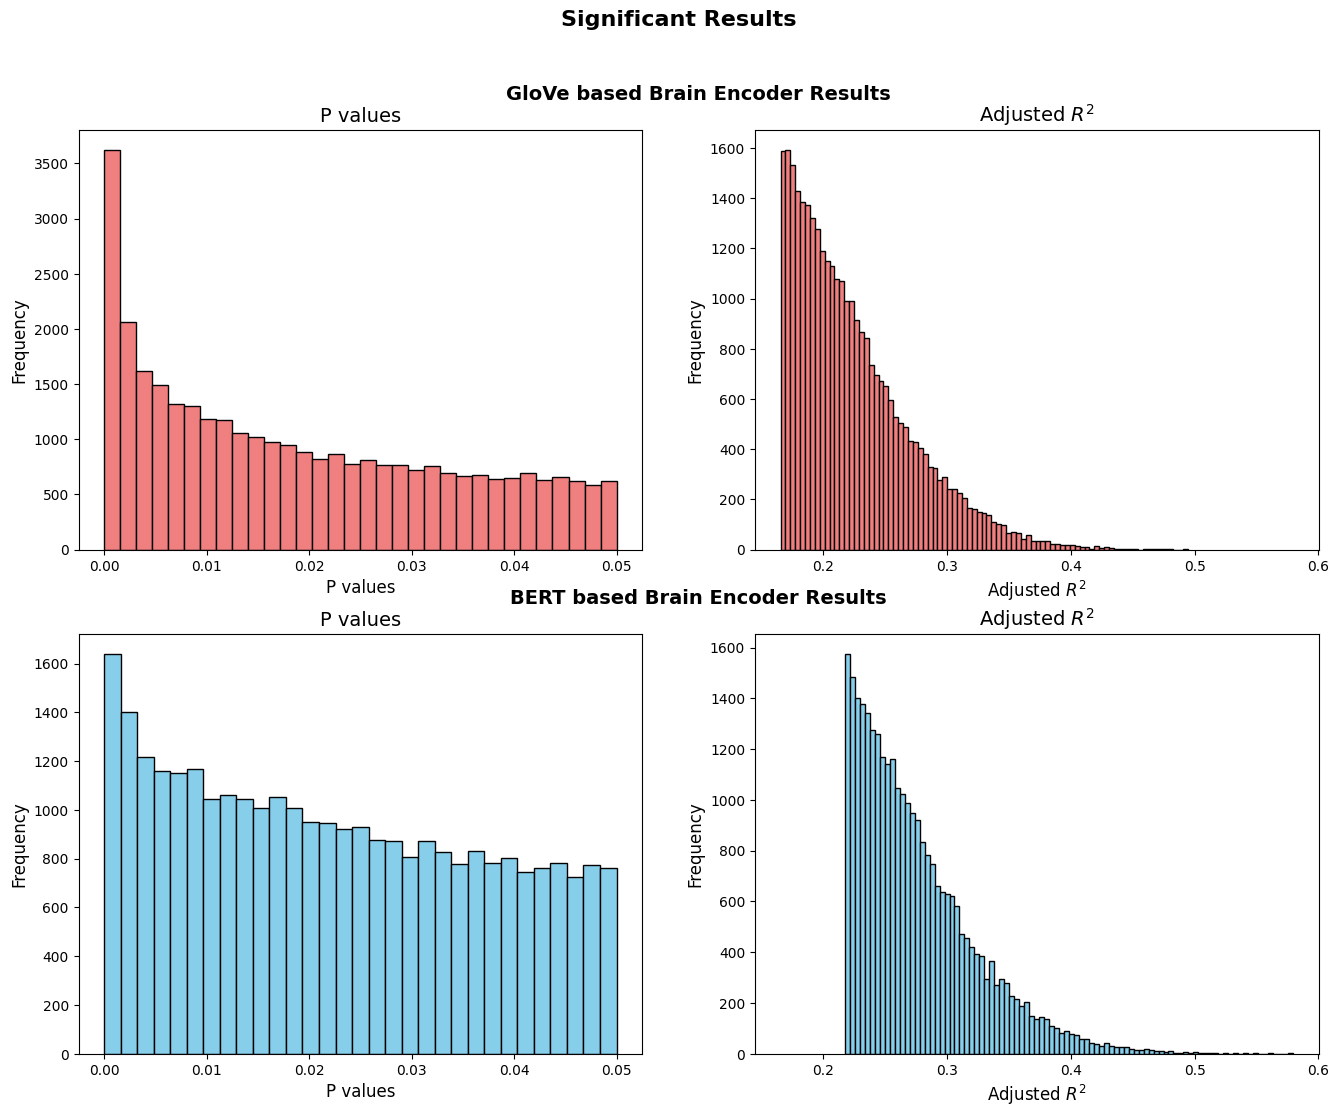

In [69]:
P_vals = {'bert':P_vals_bert,'glove':P_vals_glove}
R_2_voxels = {'bert':R_2_voxels_bert,'glove':R_2_voxels_glove}
R_2_adj_voxels =  {'bert':R_2_adj_voxels_bert,'glove':R_2_adj_voxels_glove}
plot_results(P_vals,R_2_voxels,R_2_adj_voxels, True, False)

In [ ]:
from transformers import BertTokenizer, BertModel
Bert_trained_model = 'prajjwal1/bert-mini'
tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-mini")
model = BertModel.from_pretrained('prajjwal1/bert-mini',output_hidden_states = True)
bert_vectors_exp3 = bert_vectors_embedding(exp3_pkl['keySentences'],tokenizer,model)
P_vals_bert_3,R_2_voxels_bert_3,R_2_adj_voxels_bert_3 = calc_regressions(bert_vectors_exp3,exp3_pkl['Fmridata'])
print_results(P_vals_bert_3,R_2_voxels_bert_3,R_2_adj_voxels_bert_3, 'BERT EXP3')

In [70]:
print_results(P_vals_bert_3,R_2_voxels_bert_3,R_2_adj_voxels_bert_3, 'BERT EXP3')

Analysis for: BERT EXP3
Voxel Analysis:
Significantly associated voxels (%): 14.12
Non-NaN p-values (%): 100.00
Mean p-value: 0.3318
Standard Deviation of p-values: 0.2607

R-squared Analysis:
Mean: 0.5563
Standard Deviation: 0.0435
Non-NaN R-squared (%): 100.00

Adjusted R-squared Analysis:
Mean: 0.0582
Standard Deviation: 0.0924
Non-NaN Adjusted R-squared (%): 100.00

Significant-Only Analysis: P_Value
Mean p-value: 0.0219
Standard Deviation of p-values: 0.0149
Mean R-squared: 0.6256
Standard Deviation of R-squared: 0.0193
Mean Adjusted R-squared: 0.2052
Standard Deviation of Adjusted R-squared: 0.0410

Significant-Only Analysis: R_2_Value
Mean p-value: nan
Standard Deviation of p-values: nan
Mean R-squared: nan
Standard Deviation of R-squared: nan
Mean Adjusted R-squared: nan
Standard Deviation of Adjusted R-squared: nan


<ipython-input-52-ca93f2fb474c>:33: RuntimeWarning: Mean of empty slice
  print("Mean p-value: {:.4f}".format(np.nanmean(P_vals[R_2_vals_sign])))
<ipython-input-52-ca93f2fb474c>:36: RuntimeWarning: Mean of empty slice
  print("Mean R-squared: {:.4f}".format(np.nanmean(R_2_voxels[R_2_vals_sign])))
<ipython-input-52-ca93f2fb474c>:39: RuntimeWarning: Mean of empty slice
  print("Mean Adjusted R-squared: {:.4f}".format(np.nanmean(R_2_adj_voxels[R_2_vals_sign])))


In [71]:
import pandas as pd
import numpy as np
import os
import pickle

# Define function to read matrix
def read_matrix(file_path, sep=" "):
    with open(file_path, 'r') as f:
        lines = f.read().splitlines()
    # Remove empty lines and strip leading/trailing whitespaces
    lines = [line.strip() for line in lines if line.strip()]
    # Split each line into parts, filter out empty strings, and convert each part to a float
    float_data = [[float(part) for part in line.split(sep) if part] for line in lines]
    return np.array(float_data)



# Directory where data files are stored
data_dir = GDRIVE_DIR

# Load Exp 1 data
exp1_file = os.path.join(data_dir, 'neuralData_for_EXP1.csv')
data_exp1 = pd.read_csv(exp1_file)
data_exp1.drop(columns=['Unnamed: 0'], inplace=True)
data_exp1 = np.array(data_exp1)


# Load Exp 1 concepts
concepts_exp1 = np.genfromtxt('stimuli_180concepts.txt', dtype=np.dtype('U'))

# Load GloVe vectors for Exp 1
glove_vectors_exp1_file = "vectors_180concepts.GV42B300.txt"
GLOVE_vectors_exp1 = read_matrix(glove_vectors_exp1_file, sep=" ")

# Load Exp 2 data
exp2_file = os.path.join(data_dir, 'EXP2.pkl')
with open(exp2_file, 'rb') as f:
    exp2_pkl = pickle.load(f)

# Load sentence averages for Exp 2
avg_sen_2_file = os.path.join(data_dir, 'vectors_384sentences.GV42B300.average.txt')
avg_sen_2 = read_matrix(avg_sen_2_file, sep=" ")

# Load Exp 3 data
exp3_file = os.path.join(data_dir, 'EXP3.pkl')
with open(exp3_file, 'rb') as f:
    exp3_pkl = pickle.load(f)

# Load sentence averages for Exp 3
avg_sen_3_file = os.path.join(data_dir, 'vectors_243sentences.GV42B300.average.txt')
avg_sen_3 = read_matrix(avg_sen_3_file, sep=" ")


In [72]:
def compute_cosine_similarity(vec_a: np.ndarray, vec_b: np.ndarray) -> float:
    return np.dot(vec_a, vec_b) / (np.sqrt(np.dot(vec_a, vec_a)) * np.sqrt(np.dot(vec_b, vec_b)))

def interpret_sentence_data_filtered (given_decoder, input_data, avg_sentence, p_values):
  mask = p_values < 0.05
  position_tracker = []
  rank_accumulator = 0
  unique_categories = list(set([x[0] for x in input_data['keyPassageCategory'][0]]))
  unique_subcategories = list(set([x[0][0] for x in input_data['keyPassages']]))
  category_accuracy_mapping = {k:[] for k in unique_categories}
  subcategory_accuracy_mapping = {k:[] for k in unique_subcategories}

  for index, voxel_data in enumerate(input_data['Fmridata']):
    decoded_result = np.dot(given_decoder, voxel_data[mask])
    correct_vector = avg_sentence[index]
    cos_similarity_mapping = {i: compute_cosine_similarity(decoded_result, v) for i, v in enumerate(avg_sentence)}
    cos_similarity_mapping = dict(sorted(cos_similarity_mapping.items(), key=lambda item: -item[1]))
    correct_concept_position = list(cos_similarity_mapping.keys()).index(index) + 1
    position_tracker.append(correct_concept_position)
    rank_accumulator += correct_concept_position

    identified_passage = input_data['labelsPassageForEachSentence'][index].item() - 1
    subcategory_data = input_data['keyPassages'][identified_passage][0][0]
    topic_identifier = input_data['labelsPassageCategory'][identified_passage].item() - 1
    category_data = input_data['keyPassageCategory'][0][topic_identifier][0]

    category_accuracy_mapping[category_data].append(correct_concept_position)
    subcategory_accuracy_mapping[subcategory_data].append(correct_concept_position)

  category_accuracy_mapping = {k: np.mean(v) for k, v in category_accuracy_mapping.items()}
  subcategory_accuracy_mapping = {k: np.mean(v) for k, v in subcategory_accuracy_mapping.items()}

  return np.mean(position_tracker), category_accuracy_mapping, subcategory_accuracy_mapping

def concept_decoding_filtered(given_decoder, input_data, thought_array, thought_vector, p_values):
  mask = p_values < 0.05
  accuracy_mapping = {}
  rank_tracker = []
  for index, voxel_data in enumerate(input_data):
    decoded_result = np.dot(given_decoder, voxel_data[mask])
    correct_vector, correct_thought = thought_vector[index], thought_array[index]
    cos_similarity_mapping = {i: compute_cosine_similarity(decoded_result, v) for i, v in enumerate(thought_vector)}
    cos_similarity_mapping = dict(sorted(cos_similarity_mapping.items(), key=lambda item: -item[1]))
    correct_thought_position = list(cos_similarity_mapping.keys()).index(index) + 1
    accuracy_mapping[correct_thought] = correct_thought_position
    rank_tracker.append(correct_thought_position)
  return np.mean(rank_tracker), accuracy_mapping

def interpret_sentence_data(given_decoder, input_data, avg_sentence):
  position_tracker = []
  rank_accumulator = 0
  unique_categories = list(set([x[0] for x in input_data['keyPassageCategory'][0]]))
  unique_subcategories = list(set([x[0][0] for x in input_data['keyPassages']]))
  category_accuracy_mapping = {k:[] for k in unique_categories}
  subcategory_accuracy_mapping = {k:[] for k in unique_subcategories}

  for index, voxel_data in enumerate(input_data['Fmridata']):
    decoded_result = np.dot(given_decoder, voxel_data)
    correct_vector = avg_sentence[index]
    cos_similarity_mapping = {i: compute_cosine_similarity(decoded_result, v) for i, v in enumerate(avg_sentence)}
    cos_similarity_mapping = dict(sorted(cos_similarity_mapping.items(), key=lambda item: -item[1]))
    correct_concept_position = list(cos_similarity_mapping.keys()).index(index) + 1
    position_tracker.append(correct_concept_position)
    rank_accumulator += correct_concept_position

    identified_passage = input_data['labelsPassageForEachSentence'][index].item() - 1
    subcategory_data = input_data['keyPassages'][identified_passage][0][0]
    topic_identifier = input_data['labelsPassageCategory'][identified_passage].item() - 1
    category_data = input_data['keyPassageCategory'][0][topic_identifier][0]

    category_accuracy_mapping[category_data].append(correct_concept_position)
    subcategory_accuracy_mapping[subcategory_data].append(correct_concept_position)

  category_accuracy_mapping = {k: np.mean(v) for k, v in category_accuracy_mapping.items()}
  subcategory_accuracy_mapping = {k: np.mean(v) for k, v in subcategory_accuracy_mapping.items()}

  return np.mean(position_tracker), category_accuracy_mapping, subcategory_accuracy_mapping

def concept_decoding(given_decoder, input_data, thought_array, thought_vector):
  accuracy_mapping = {}
  rank_tracker = []
  for index, voxel_data in enumerate(input_data):
    decoded_result = np.dot(given_decoder, voxel_data)
    correct_vector, correct_thought = thought_vector[index], thought_array[index]
    cos_similarity_mapping = {i: compute_cosine_similarity(decoded_result, v) for i, v in enumerate(thought_vector)}
    cos_similarity_mapping = dict(sorted(cos_similarity_mapping.items(), key=lambda item: -item[1]))
    correct_thought_position = list(cos_similarity_mapping.keys()).index(index) + 1
    accuracy_mapping[correct_thought] = correct_thought_position
    rank_tracker.append(correct_thought_position)
  return np.mean(rank_tracker), accuracy_mapping

def extract_topics(input_data):
    collected_topics = []
    collected_subtopics = []
    for index, _ in enumerate(input_data['Fmridata']):
        passage_index = input_data['labelsPassageForEachSentence'][index].item() - 1
        subtopic_info = input_data['keyPassages'][passage_index][0][0]
        topic_index = input_data['labelsPassageCategory'][passage_index].item() - 1
        topic_info = input_data['keyPassageCategory'][0][topic_index][0]

        if subtopic_info not in collected_subtopics:
            collected_subtopics.append(subtopic_info)
        if topic_info not in collected_topics:
            collected_topics.append(topic_info)
    return collected_topics, collected_subtopics


# Training on Exp2 and evaluations on Exp1, Exp3

In [84]:
p_val_threshold = 0.05
significant_voxels_mask_glove = P_vals_glove < p_val_threshold
significant_voxels_mask_bert = P_vals_bert < p_val_threshold
significant_voxels_mask_bert_ex3 = P_vals_bert_3 < p_val_threshold

In [74]:
from transformers import BertTokenizer, BertModel

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-mini")
model = BertModel.from_pretrained('prajjwal1/bert-mini', output_hidden_states=True)

def extract_bert_embeddings(data, tokenizer, model, exp1_flag=0):
    """
    Extract BERT embeddings for the provided data
    """
    bert_embeddings = []
    flag = isinstance(data[0], np.ndarray)

    for item in data:
        item = item[0][0].item() if flag else item
        inputs = tokenizer(item, return_tensors="pt")
        outputs = model(**inputs)
        cls_token = outputs.last_hidden_state.squeeze()[exp1_flag].detach().numpy()
        bert_embeddings.append(cls_token)

    return np.array(bert_embeddings)

# Extract BERT embeddings for each exp
bert_embeddings_exp1 = extract_bert_embeddings(concepts_exp1, tokenizer, model, 1)
bert_embeddings_exp2 = extract_bert_embeddings(exp2_pkl['keySentences'], tokenizer, model)
bert_embeddings_exp3 = extract_bert_embeddings(exp3_pkl['keySentences'], tokenizer, model)

Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## GLoVE WITH MASK

In [75]:
# Establish the GloVe decoder for exp 2
exp2_decoder_glove = learn_decoder(exp2_pkl['Fmridata'], avg_sen_2).T
exp2_decoder_glove = exp2_decoder_glove[:, significant_voxels_mask_glove]
# Decoding sentences for exp 3
exp3_glv_accuracy, exp3_glv_topic_acc, exp3_glv_subtopic_acc = interpret_sentence_data_filtered(exp2_decoder_glove, exp3_pkl, avg_sen_3, P_vals_glove)

# Decoding concepts for exp 1
exp1_glv_accuracy, exp1_glv_concepts_acc = concept_decoding_filtered(exp2_decoder_glove, data_exp1, concepts_exp1,GLOVE_vectors_exp1, P_vals_glove)

# Decoding sentences for exp 2
exp2_glv_accuracy, exp2_glv_topic_acc, exp2_glv_subtopic_acc = interpret_sentence_data_filtered(exp2_decoder_glove, exp2_pkl, avg_sen_2, P_vals_glove)

## BERT WITH MASK

In [76]:
# Create the sentence decoder for experiment 2 using BERT vectors
sentence_decoder_exp2_bert = learn_decoder(exp2_pkl['Fmridata'], bert_embeddings_exp2).T
sentence_decoder_exp2_bert = sentence_decoder_exp2_bert[:, significant_voxels_mask_bert]

# Interpret the sentence data for experiment 3 using the created decoder
accuracy_exp3_bert, topic_acc_exp3_bert, subtopic_acc_exp3_bert = interpret_sentence_data_filtered(
    sentence_decoder_exp2_bert, exp3_pkl, bert_embeddings_exp3, P_vals_bert
)

# Interpret the thought data for experiment 1 using the created decoder
accuracy_exp1_bert, concepts_acc_exp1_bert = concept_decoding_filtered(
    sentence_decoder_exp2_bert, data_exp1, concepts_exp1, bert_embeddings_exp1, P_vals_bert
)

# Interpret the sentence data for experiment 2 using the created decoder
accuracy_exp2_bert, topic_acc_exp2_bert, subtopic_acc_exp2_bert = interpret_sentence_data_filtered(
    sentence_decoder_exp2_bert, exp2_pkl, bert_embeddings_exp2, P_vals_bert
)


In [77]:
print("Training on: Exp2")
print("Testing on: Exp1, Exp3")
print()

print("Normalized average accuracies - ")
print(f'Accuracy GloVe on Exp1: {exp1_glv_accuracy/180}, Accuracy Bert on Exp1: {accuracy_exp1_bert/180}')
print(f'Accuracy GloVe on Exp2: {exp2_glv_accuracy/384}, Accuracy Bert on Exp2: {accuracy_exp2_bert/384}')
print(f'Accuracy GloVe on Exp3: {exp3_glv_accuracy/243}, Accuracy Bert on Exp3: {accuracy_exp3_bert/243}')

print("Raw average accuracies - ")
print(f'Accuracy GloVe on Exp1: {exp1_glv_accuracy}, Accuracy Bert on Exp1: {accuracy_exp1_bert}')
print(f'Accuracy GloVe on Exp2: {exp2_glv_accuracy}, Accuracy Bert on Exp2: {accuracy_exp2_bert}')
print(f'Accuracy GloVe on Exp3: {exp3_glv_accuracy}, Accuracy Bert on Exp3: {accuracy_exp3_bert}')

print()

# Sorting topics and concepts based on accuracy
topic_acc_exp3_glv_sorted = sorted(exp3_glv_topic_acc.items(), key=lambda item: item[1])
topic_acc_exp3_bert_sorted = sorted(topic_acc_exp3_bert.items(), key=lambda item: item[1])
concepts_acc_exp1_bert_sorted = sorted(concepts_acc_exp1_bert.items(), key=lambda item: item[1])
concepts_acc_exp1_glv_sorted = sorted(exp1_glv_concepts_acc.items(), key=lambda item: item[1])

n=8

# Printing the top and bottom n topics/concepts based on accuracy
print('Best Decoded Topics')
print('For Exp3 and GloVe:')
print(topic_acc_exp3_glv_sorted[0:n])
print('For Exp3 and Bert:')
print(topic_acc_exp3_bert_sorted[0:n])
print('For Exp1 and GloVe:')
print(concepts_acc_exp1_glv_sorted[0:n])
print('For Exp1 and Bert:')
print(concepts_acc_exp1_bert_sorted[0:n])
print()
print('Worst Decoded Topics')
print('For Exp3 and GloVe:')
print(topic_acc_exp3_glv_sorted[-n:])
print('For Exp3 and Bert:')
print(topic_acc_exp3_bert_sorted[-n:])
print('For Exp1 and GloVe:')
print(concepts_acc_exp1_glv_sorted[-n:])
print('For Exp1 and Bert:')
print(concepts_acc_exp1_bert_sorted[-n:])
print()


Training on: Exp2
Testing on: Exp1, Exp3

Normalized average accuracies - 
Accuracy GloVe on Exp1: 0.4169135802469136, Accuracy Bert on Exp1: 0.4559876543209877
Accuracy GloVe on Exp2: 0.004584418402777778, Accuracy Bert on Exp2: 0.013936360677083334
Accuracy GloVe on Exp3: 0.3080492472353469, Accuracy Bert on Exp3: 0.3168216227201138
Raw average accuracies - 
Accuracy GloVe on Exp1: 75.04444444444445, Accuracy Bert on Exp1: 82.07777777777778
Accuracy GloVe on Exp2: 1.7604166666666667, Accuracy Bert on Exp2: 5.3515625
Accuracy GloVe on Exp3: 74.8559670781893, Accuracy Bert on Exp3: 76.98765432098766

Best Decoded Topics
For Exp3 and GloVe:
[('ice_cream', 11.8), ('law_school', 36.8), ('taste', 40.333333333333336), ('dreams', 43.8), ('beekeeping', 48.81818181818182), ('lawn_mower', 50.7), ('gambling', 51.7), ('polar_bear', 51.8)]
For Exp3 and Bert:
[('lawn_mower', 27.6), ('polar_bear', 28.5), ('beekeeping', 36.45454545454545), ('ice_cream', 47.1), ('rock_climbing', 49.63636363636363), ('

## GloVE WITHOUT MASK

In [78]:
# Establish the GloVe decoder for exp 2
exp2_decoder_glove = learn_decoder(exp2_pkl['Fmridata'], avg_sen_2).T
# Decoding sentences for exp 3
exp3_glv_accuracy, exp3_glv_topic_acc, exp3_glv_subtopic_acc = interpret_sentence_data(exp2_decoder_glove, exp3_pkl, avg_sen_3)

# Decoding concepts for exp 1
exp1_glv_accuracy, exp1_glv_concepts_acc = concept_decoding(exp2_decoder_glove, data_exp1, concepts_exp1,GLOVE_vectors_exp1)

# Decoding sentences for exp 2
exp2_glv_accuracy, exp2_glv_topic_acc, exp2_glv_subtopic_acc = interpret_sentence_data(exp2_decoder_glove, exp2_pkl, avg_sen_2)

## BERT WITHOUT MASK

In [79]:
# Create the sentence decoder for experiment 2 using BERT vectors
sentence_decoder_exp2_bert = learn_decoder(exp2_pkl['Fmridata'], bert_embeddings_exp2).T

# Interpret the sentence data for experiment 3 using the created decoder
accuracy_exp3_bert, topic_acc_exp3_bert, subtopic_acc_exp3_bert = interpret_sentence_data(
    sentence_decoder_exp2_bert, exp3_pkl, bert_embeddings_exp3
)

# Interpret the thought data for experiment 1 using the created decoder
accuracy_exp1_bert, concepts_acc_exp1_bert = concept_decoding(
    sentence_decoder_exp2_bert, data_exp1, concepts_exp1, bert_embeddings_exp1
)

# Interpret the sentence data for experiment 2 using the created decoder
accuracy_exp2_bert, topic_acc_exp2_bert, subtopic_acc_exp2_bert = interpret_sentence_data(
    sentence_decoder_exp2_bert, exp2_pkl, bert_embeddings_exp2)

In [80]:
print("Training on: Exp2")
print("Testing on: Exp1, Exp3")
print()

print("Normalized average accuracies - ")
print(f'Accuracy GloVe on Exp1: {exp1_glv_accuracy/180}, Accuracy Bert on Exp1: {accuracy_exp1_bert/180}')
print(f'Accuracy GloVe on Exp2: {exp2_glv_accuracy/384}, Accuracy Bert on Exp2: {accuracy_exp2_bert/384}')
print(f'Accuracy GloVe on Exp3: {exp3_glv_accuracy/243}, Accuracy Bert on Exp3: {accuracy_exp3_bert/243}')

print("Raw average accuracies - ")
print(f'Accuracy GloVe on Exp1: {exp1_glv_accuracy}, Accuracy Bert on Exp1: {accuracy_exp1_bert}')
print(f'Accuracy GloVe on Exp2: {exp2_glv_accuracy}, Accuracy Bert on Exp2: {accuracy_exp2_bert}')
print(f'Accuracy GloVe on Exp3: {exp3_glv_accuracy}, Accuracy Bert on Exp3: {accuracy_exp3_bert}')

print()

# Sorting topics and concepts based on accuracy
topic_acc_exp3_glv_sorted = sorted(exp3_glv_topic_acc.items(), key=lambda item: item[1])
topic_acc_exp3_bert_sorted = sorted(topic_acc_exp3_bert.items(), key=lambda item: item[1])
concepts_acc_exp1_bert_sorted = sorted(concepts_acc_exp1_bert.items(), key=lambda item: item[1])
concepts_acc_exp1_glv_sorted = sorted(exp1_glv_concepts_acc.items(), key=lambda item: item[1])

n=8

# Printing the top and bottom n topics/concepts based on accuracy
print('Best Decoded Topics')
print('For Exp3 and GloVe:')
print(topic_acc_exp3_glv_sorted[0:n])
print('For Exp3 and Bert:')
print(topic_acc_exp3_bert_sorted[0:n])
print('For Exp1 and GloVe:')
print(concepts_acc_exp1_glv_sorted[0:n])
print('For Exp1 and Bert:')
print(concepts_acc_exp1_bert_sorted[0:n])
print()
print('Worst Decoded Topics')
print('For Exp3 and GloVe:')
print(topic_acc_exp3_glv_sorted[-n:])
print('For Exp3 and Bert:')
print(topic_acc_exp3_bert_sorted[-n:])
print('For Exp1 and GloVe:')
print(concepts_acc_exp1_glv_sorted[-n:])
print('For Exp1 and Bert:')
print(concepts_acc_exp1_bert_sorted[-n:])
print()


Training on: Exp2
Testing on: Exp1, Exp3

Normalized average accuracies - 
Accuracy GloVe on Exp1: 0.4446913580246914, Accuracy Bert on Exp1: 0.4633024691358025
Accuracy GloVe on Exp2: 0.0026109483506944445, Accuracy Bert on Exp2: 0.0026041666666666665
Accuracy GloVe on Exp3: 0.38847397923758237, Accuracy Bert on Exp3: 0.38244508797778115
Raw average accuracies - 
Accuracy GloVe on Exp1: 80.04444444444445, Accuracy Bert on Exp1: 83.39444444444445
Accuracy GloVe on Exp2: 1.0026041666666667, Accuracy Bert on Exp2: 1.0
Accuracy GloVe on Exp3: 94.39917695473251, Accuracy Bert on Exp3: 92.93415637860082

Best Decoded Topics
For Exp3 and GloVe:
[('polar_bear', 34.1), ('taste', 50.44444444444444), ('ice_cream', 57.5), ('dreams', 68.4), ('law_school', 71.7), ('hurricane', 78.3), ('painter', 79.8), ('infection', 84.0)]
For Exp3 and Bert:
[('beekeeping', 32.63636363636363), ('polar_bear', 32.9), ('lawn_mower', 34.6), ('taste', 51.55555555555556), ('infection', 51.6), ('rock_climbing', 63.8181818

# Training on Exp3 and evaluations on Exp1, Exp2

# GloVe WITH MASK

In [82]:
# Establish the GloVe decoder for exp 2
exp3_decoder_glove = learn_decoder(exp3_pkl['Fmridata'], avg_sen_3).T
exp3_decoder_glove = exp3_decoder_glove[:, significant_voxels_mask_glove]

# Decoding sentences for exp 3
exp3_glv_accuracy, exp3_glv_topic_acc, exp3_glv_subtopic_acc = interpret_sentence_data_filtered(exp3_decoder_glove, exp3_pkl, avg_sen_3, P_vals_glove)

# Decoding concepts for exp 1
exp1_glv_accuracy, exp1_glv_concepts_acc = concept_decoding_filtered(exp3_decoder_glove, data_exp1, concepts_exp1,GLOVE_vectors_exp1, P_vals_glove)

# Decoding sentences for exp 2
exp2_glv_accuracy, exp2_glv_topic_acc, exp2_glv_subtopic_acc = interpret_sentence_data_filtered(exp3_decoder_glove, exp2_pkl, avg_sen_2, P_vals_glove)

## BERT WITH MASK

In [86]:
# Create the sentence decoder for experiment 2 using BERT vectors
sentence_decoder_exp3_bert = learn_decoder(exp3_pkl['Fmridata'], bert_embeddings_exp3).T
sentence_decoder_exp3_bert = sentence_decoder_exp3_bert[:, significant_voxels_mask_bert_ex3]
# Interpret the sentence data for experiment 3 using the created decoder
accuracy_exp3_bert, topic_acc_exp3_bert, subtopic_acc_exp3_bert = interpret_sentence_data_filtered(
    sentence_decoder_exp3_bert, exp3_pkl, bert_embeddings_exp3, P_vals_bert_3
)

# Interpret the thought data for experiment 1 using the created decoder
accuracy_exp1_bert, concepts_acc_exp1_bert = concept_decoding_filtered(
    sentence_decoder_exp3_bert, data_exp1, concepts_exp1, bert_embeddings_exp1, P_vals_bert_3
)

# Interpret the sentence data for experiment 2 using the created decoder
accuracy_exp2_bert, topic_acc_exp2_bert, subtopic_acc_exp2_bert = interpret_sentence_data_filtered(
    sentence_decoder_exp3_bert, exp2_pkl, bert_embeddings_exp2, P_vals_bert_3
)

In [87]:
print("Training on: Exp3")
print("Testing on: Exp1, Exp2")
print()

print("Normalized average accuracies - ")
print(f'Accuracy GloVe on Exp1: {exp1_glv_accuracy/180}, Accuracy Bert on Exp1: {accuracy_exp1_bert/180}')
print(f'Accuracy GloVe on Exp2: {exp2_glv_accuracy/384}, Accuracy Bert on Exp2: {accuracy_exp2_bert/384}')
print(f'Accuracy GloVe on Exp3: {exp3_glv_accuracy/243}, Accuracy Bert on Exp3: {accuracy_exp3_bert/243}')

print("Raw average accuracies - ")
print(f'Accuracy GloVe on Exp1: {exp1_glv_accuracy}, Accuracy Bert on Exp1: {accuracy_exp1_bert}')
print(f'Accuracy GloVe on Exp2: {exp2_glv_accuracy}, Accuracy Bert on Exp2: {accuracy_exp2_bert}')
print(f'Accuracy GloVe on Exp3: {exp3_glv_accuracy}, Accuracy Bert on Exp3: {accuracy_exp3_bert}')

print()

# Sorting topics and concepts based on accuracy
topic_acc_exp2_glv_sorted = sorted(exp2_glv_topic_acc.items(), key=lambda item: item[1])
topic_acc_exp2_bert_sorted = sorted(topic_acc_exp2_bert.items(), key=lambda item: item[1])
concepts_acc_exp1_bert_sorted = sorted(concepts_acc_exp1_bert.items(), key=lambda item: item[1])
concepts_acc_exp1_glv_sorted = sorted(exp1_glv_concepts_acc.items(), key=lambda item: item[1])

n=8

# Printing the top and bottom n topics/concepts based on accuracy
print('Best Decoded Topics')
print('For Exp2 and GloVe:')
print(topic_acc_exp2_glv_sorted[0:n])
print('For Exp2 and Bert:')
print(topic_acc_exp2_bert_sorted[0:n])
print('For Exp1 and GloVe:')
print(concepts_acc_exp1_glv_sorted[0:n])
print('For Exp1 and Bert:')
print(concepts_acc_exp1_bert_sorted[0:n])
print()
print('Worst Decoded Topics')
print('For Exp2 and GloVe:')
print(topic_acc_exp2_glv_sorted[-n:])
print('For Exp2 and Bert:')
print(topic_acc_exp2_bert_sorted[-n:])
print('For Exp1 and GloVe:')
print(concepts_acc_exp1_glv_sorted[-n:])
print('For Exp1 and Bert:')
print(concepts_acc_exp1_bert_sorted[-n:])
print()

Training on: Exp3
Testing on: Exp1, Exp2

Normalized average accuracies - 
Accuracy GloVe on Exp1: 0.4558950617283951, Accuracy Bert on Exp1: 0.4855864197530864
Accuracy GloVe on Exp2: 0.3512708875868056, Accuracy Bert on Exp2: 0.3371988932291667
Accuracy GloVe on Exp3: 0.005266812308421819, Accuracy Bert on Exp3: 0.005402293010889261
Raw average accuracies - 
Accuracy GloVe on Exp1: 82.06111111111112, Accuracy Bert on Exp1: 87.40555555555555
Accuracy GloVe on Exp2: 134.88802083333334, Accuracy Bert on Exp2: 129.484375
Accuracy GloVe on Exp3: 1.2798353909465021, Accuracy Bert on Exp3: 1.3127572016460904

Best Decoded Topics
For Exp2 and GloVe:
[('drink_non_alcoholic', 70.0625), ('human', 71.625), ('fruit', 83.4375), ('body_part', 95.875), ('animal', 107.5625), ('furniture', 115.0), ('appliance', 117.4375), ('place', 122.875)]
For Exp2 and Bert:
[('human', 72.9375), ('appliance', 85.875), ('profession', 86.8125), ('body_part', 100.375), ('insect', 100.875), ('place', 100.9375), ('crime'

# GLoVE WITHOUT MASK

In [88]:
# Establish the GloVe decoder for exp 2
exp3_decoder_glove = learn_decoder(exp3_pkl['Fmridata'], avg_sen_3).T

# Decoding sentences for exp 3
exp3_glv_accuracy, exp3_glv_topic_acc, exp3_glv_subtopic_acc = interpret_sentence_data(exp3_decoder_glove, exp3_pkl, avg_sen_3)

# Decoding concepts for exp 1
exp1_glv_accuracy, exp1_glv_concepts_acc = concept_decoding(exp3_decoder_glove, data_exp1, concepts_exp1,GLOVE_vectors_exp1)

# Decoding sentences for exp 2
exp2_glv_accuracy, exp2_glv_topic_acc, exp2_glv_subtopic_acc = interpret_sentence_data(exp3_decoder_glove, exp2_pkl, avg_sen_2)

## BERT WITHOUT MASK

In [89]:
# Create the sentence decoder for experiment 2 using BERT vectors
sentence_decoder_exp3_bert = learn_decoder(exp3_pkl['Fmridata'], bert_embeddings_exp3).T

# Interpret the sentence data for experiment 3 using the created decoder
accuracy_exp3_bert, topic_acc_exp3_bert, subtopic_acc_exp3_bert = interpret_sentence_data(
    sentence_decoder_exp3_bert, exp3_pkl, bert_embeddings_exp3
)

# Interpret the thought data for experiment 1 using the created decoder
accuracy_exp1_bert, concepts_acc_exp1_bert = concept_decoding(
    sentence_decoder_exp3_bert, data_exp1, concepts_exp1, bert_embeddings_exp1
)

# Interpret the sentence data for experiment 2 using the created decoder
accuracy_exp2_bert, topic_acc_exp2_bert, subtopic_acc_exp2_bert = interpret_sentence_data(
    sentence_decoder_exp3_bert, exp2_pkl, bert_embeddings_exp2
)

In [90]:
print("Training on: Exp3")
print("Testing on: Exp1, Exp2")
print()

print("Normalized average accuracies - ")
print(f'Accuracy GloVe on Exp1: {exp1_glv_accuracy/180}, Accuracy Bert on Exp1: {accuracy_exp1_bert/180}')
print(f'Accuracy GloVe on Exp2: {exp2_glv_accuracy/384}, Accuracy Bert on Exp2: {accuracy_exp2_bert/384}')
print(f'Accuracy GloVe on Exp3: {exp3_glv_accuracy/243}, Accuracy Bert on Exp3: {accuracy_exp3_bert/243}')

print("Raw average accuracies - ")
print(f'Accuracy GloVe on Exp1: {exp1_glv_accuracy}, Accuracy Bert on Exp1: {accuracy_exp1_bert}')
print(f'Accuracy GloVe on Exp2: {exp2_glv_accuracy}, Accuracy Bert on Exp2: {accuracy_exp2_bert}')
print(f'Accuracy GloVe on Exp3: {exp3_glv_accuracy}, Accuracy Bert on Exp3: {accuracy_exp3_bert}')

print()

# Sorting topics and concepts based on accuracy
topic_acc_exp2_glv_sorted = sorted(exp2_glv_topic_acc.items(), key=lambda item: item[1])
topic_acc_exp2_bert_sorted = sorted(topic_acc_exp2_bert.items(), key=lambda item: item[1])
concepts_acc_exp1_bert_sorted = sorted(concepts_acc_exp1_bert.items(), key=lambda item: item[1])
concepts_acc_exp1_glv_sorted = sorted(exp1_glv_concepts_acc.items(), key=lambda item: item[1])

n=8

# Printing the top and bottom n topics/concepts based on accuracy
print('Best Decoded Topics')
print('For Exp2 and GloVe:')
print(topic_acc_exp2_glv_sorted[0:n])
print('For Exp2 and Bert:')
print(topic_acc_exp2_bert_sorted[0:n])
print('For Exp1 and GloVe:')
print(concepts_acc_exp1_glv_sorted[0:n])
print('For Exp1 and Bert:')
print(concepts_acc_exp1_bert_sorted[0:n])
print()
print('Worst Decoded Topics')
print('For Exp2 and GloVe:')
print(topic_acc_exp2_glv_sorted[-n:])
print('For Exp2 and Bert:')
print(topic_acc_exp2_bert_sorted[-n:])
print('For Exp1 and GloVe:')
print(concepts_acc_exp1_glv_sorted[-n:])
print('For Exp1 and Bert:')
print(concepts_acc_exp1_bert_sorted[-n:])
print()

Training on: Exp3
Testing on: Exp1, Exp2

Normalized average accuracies - 
Accuracy GloVe on Exp1: 0.46361111111111114, Accuracy Bert on Exp1: 0.4920987654320988
Accuracy GloVe on Exp2: 0.3953450520833333, Accuracy Bert on Exp2: 0.34374321831597227
Accuracy GloVe on Exp3: 0.00411522633744856, Accuracy Bert on Exp3: 0.00411522633744856
Raw average accuracies - 
Accuracy GloVe on Exp1: 83.45, Accuracy Bert on Exp1: 88.57777777777778
Accuracy GloVe on Exp2: 151.8125, Accuracy Bert on Exp2: 131.99739583333334
Accuracy GloVe on Exp3: 1.0, Accuracy Bert on Exp3: 1.0

Best Decoded Topics
For Exp2 and GloVe:
[('dwelling', 88.6875), ('human', 93.5), ('body_part', 93.625), ('drink_non_alcoholic', 100.5), ('furniture', 105.1875), ('place', 105.5), ('building_part', 112.0), ('tool', 125.1875)]
For Exp2 and Bert:
[('human', 58.8125), ('body_part', 93.375), ('tool', 96.5), ('profession', 101.5625), ('appliance', 102.25), ('place', 111.375), ('disaster', 113.0), ('insect', 114.875)]
For Exp1 and GloV

# Training on Exp1: and evaluations on Exp3, Exp2

# GloVe:

In [93]:
# Establish the GloVe decoder for exp 2
exp1_decoder_glove = learn_decoder(data_exp1, GLOVE_vectors_exp1).T

# Decoding sentences for exp 3
exp3_glv_accuracy, exp3_glv_topic_acc, exp3_glv_subtopic_acc = interpret_sentence_data(exp1_decoder_glove, exp3_pkl, avg_sen_3)

# Decoding concepts for exp 1
exp1_glv_accuracy, exp1_glv_concepts_acc = concept_decoding(exp1_decoder_glove, data_exp1, concepts_exp1,GLOVE_vectors_exp1)

# Decoding sentences for exp 2
exp2_glv_accuracy, exp2_glv_topic_acc, exp2_glv_subtopic_acc = interpret_sentence_data(exp1_decoder_glove, exp2_pkl, avg_sen_2)

## BERT

In [94]:
# Create the sentence decoder for experiment 2 using BERT vectors
sentence_decoder_exp1_bert = learn_decoder(data_exp1, bert_embeddings_exp1).T

# Interpret the sentence data for experiment 3 using the created decoder
accuracy_exp3_bert, topic_acc_exp3_bert, subtopic_acc_exp3_bert = interpret_sentence_data(
    sentence_decoder_exp1_bert, exp3_pkl, bert_embeddings_exp3
)

# Interpret the thought data for experiment 1 using the created decoder
accuracy_exp1_bert, concepts_acc_exp1_bert = concept_decoding(
    sentence_decoder_exp1_bert, data_exp1, concepts_exp1, bert_embeddings_exp1
)

# Interpret the sentence data for experiment 2 using the created decoder
accuracy_exp2_bert, topic_acc_exp2_bert, subtopic_acc_exp2_bert = interpret_sentence_data(
    sentence_decoder_exp1_bert, exp2_pkl, bert_embeddings_exp2
)

In [95]:
print("Training on: Exp1")
print("Testing on: Exp3, Exp2")
print()

print("Normalized average accuracies - ")
print(f'Accuracy GloVe on Exp1: {exp1_glv_accuracy/180}, Accuracy Bert on Exp1: {accuracy_exp1_bert/180}')
print(f'Accuracy GloVe on Exp2: {exp2_glv_accuracy/384}, Accuracy Bert on Exp2: {accuracy_exp2_bert/384}')
print(f'Accuracy GloVe on Exp3: {exp3_glv_accuracy/243}, Accuracy Bert on Exp3: {accuracy_exp3_bert/243}')

print("Raw average accuracies - ")
print(f'Accuracy GloVe on Exp1: {exp1_glv_accuracy}, Accuracy Bert on Exp1: {accuracy_exp1_bert}')
print(f'Accuracy GloVe on Exp2: {exp2_glv_accuracy}, Accuracy Bert on Exp2: {accuracy_exp2_bert}')
print(f'Accuracy GloVe on Exp3: {exp3_glv_accuracy}, Accuracy Bert on Exp3: {accuracy_exp3_bert}')

print()

# Sorting topics and concepts based on accuracy
topic_acc_exp2_glv_sorted = sorted(exp2_glv_topic_acc.items(), key=lambda item: item[1])
topic_acc_exp2_bert_sorted = sorted(topic_acc_exp2_bert.items(), key=lambda item: item[1])
topic_acc_exp3_glv_sorted = sorted(exp3_glv_topic_acc.items(), key=lambda item: item[1])
topic_acc_exp3_bert_sorted = sorted(topic_acc_exp3_bert.items(), key=lambda item: item[1])

# Printing the top and bottom n topics/concepts based on accuracy
print('Best Decoded Topics')
print('For Exp2 and GloVe:')
print(topic_acc_exp2_glv_sorted[0:n])
print('For Exp2 and Bert:')
print(topic_acc_exp2_bert_sorted[0:n])
print('For Exp3 and GloVe:')
print(topic_acc_exp3_glv_sorted[0:n])
print('For Exp3 and Bert:')
print(topic_acc_exp3_bert_sorted[0:n])
print()
print('Worst Decoded Topics')
print('For Exp2 and GloVe:')
print(topic_acc_exp2_glv_sorted[-n:])
print('For Exp2 and Bert:')
print(topic_acc_exp2_bert_sorted[-n:])
print('For Exp3 and GloVe:')
print(topic_acc_exp3_glv_sorted[-n:])
print('For Exp3 and Bert:')
print(topic_acc_exp3_bert_sorted[-n:])
print()

Training on: Exp1
Testing on: Exp3, Exp2

Normalized average accuracies - 
Accuracy GloVe on Exp1: 0.005555555555555556, Accuracy Bert on Exp1: 0.005555555555555556
Accuracy GloVe on Exp2: 0.4086642795138889, Accuracy Bert on Exp2: 0.4550577799479167
Accuracy GloVe on Exp3: 0.41458788463818186, Accuracy Bert on Exp3: 0.4791275042761097
Raw average accuracies - 
Accuracy GloVe on Exp1: 1.0, Accuracy Bert on Exp1: 1.0
Accuracy GloVe on Exp2: 156.92708333333334, Accuracy Bert on Exp2: 174.7421875
Accuracy GloVe on Exp3: 100.7448559670782, Accuracy Bert on Exp3: 116.42798353909465

Best Decoded Topics
For Exp2 and GloVe:
[('body_part', 70.4375), ('human', 92.75), ('drink_non_alcoholic', 98.9375), ('dwelling', 113.6875), ('appliance', 113.75), ('furniture', 131.875), ('kitchen_utensil', 141.25), ('disaster', 149.3125)]
For Exp2 and Bert:
[('human', 51.375), ('crime', 67.9375), ('body_part', 77.4375), ('appliance', 136.25), ('animal', 148.875), ('landscape', 149.9375), ('tool', 155.875), ('m

In [96]:
print("Retrieving Topics from Experiment 2...")
exp2_topics, exp2_subtopics = extract_topics(exp2_pkl)
print("Topics from Experiment 2:")
for idx in range(0, len(exp2_topics), 6):
  print(exp2_topics[idx:idx+6])
print("\nSubtopics from Experiment 2:")
print(exp2_subtopics)

print("\nRetrieving Topics from Experiment 3...")
exp3_topics, exp3_subtopics = extract_topics(exp3_pkl)
print("Topics from Experiment 3:")
for idx in range(0, len(exp3_topics), 6):
  print(exp3_topics[idx:idx+6])

print("\nConcepts from Experiment 1:")
print(concepts_exp1)

Retrieving Topics from Experiment 2...
Topics from Experiment 2:
['music', 'dwelling', 'fruit', 'crime', 'vehicles_transport', 'weapon']
['furniture', 'insect', 'profession', 'appliance', 'human', 'vegetable']
['animal', 'fish', 'drink_non_alcoholic', 'landscape', 'building_part', 'clothing']
['disaster', 'bird', 'body_part', 'place', 'kitchen_utensil', 'tool']

Subtopics from Experiment 2:
['Accordion', 'Apartment', 'Apple', 'Arson', 'Automobile', 'Axe', 'Banana', 'Bed', 'Bee', 'Bicycle', 'Blacksmith', 'Blender', 'Boy', 'Broccoli', 'Butterfly', 'Carpenter', 'Cat', 'Chair', 'Clarinet', 'Cod', 'Coffee', 'Desert', 'Desk', 'Door', 'Dress', 'Driving_under_the_influence', 'Drought', 'Eagle', 'Earthquake', 'Elephant', 'Eye', 'Farm', 'Finger', 'Flood', 'Floor', 'Foot', 'Forest', 'Fork', 'Frying_pan', 'Girl', 'Glove', 'Hammer', 'Hand_grenade', 'Horse', 'Hospital', 'House', 'Igloo', 'Knife', 'Lentil', 'Lettuce', 'Library', 'Log_cabin', 'Man', 'Milk', 'Mosquito', 'Mountain', 'Mouth', 'Mug', 'Mur